# Multivariate Forecasting

In earlier tutorials we worked with a single time series (one column). In practice, you will often need to forecast **several variables simultaneously** — GDP and unemployment, temperature and humidity, sales and marketing spend, etc.

A time series with more than one measured variable at each time point is called **multivariate**. sktime represents multivariate series as a plain `pandas.DataFrame` where each column is a variable and the index is a time axis.

> **Panel vs. multivariate — what's the difference?**
>
> | Concept | Meaning | sktime format |
> |---|---|---|
> | **Panel** | Many *independent* series (one column each), e.g., sales per store | `DataFrame` with `MultiIndex` rows |
> | **Multivariate** | One series with *multiple columns* measured together | `DataFrame` with regular time index, multiple columns |
>
> This tutorial covers the **multivariate** case. See the [Panel Forecasting tutorial](07_panel_forecasting.ipynb) for the panel case.

This tutorial covers three complementary strategies:

| Strategy | Idea |
|---|---|
| **Apply-by-column (broadcast)** | Use any univariate forecaster — sktime fits one model per column automatically |
| **Genuine multivariate** | Use a forecaster that models cross-variable dependencies (e.g., VAR, VECM) |
| **Reduction** | Turn the multivariate problem into a tabular regression problem with lag features |

**Duration:** ~15 minutes

## Learning objectives

By the end of this tutorial you will be able to:
- Understand how sktime represents multivariate time series
- Forecast multivariate data using univariate forecasters (apply-by-column)
- Use genuine multivariate forecasters such as VAR and VECM
- Use reduction-based approaches (VARReduce) with scikit-learn regressors
- Assign different forecasters to different columns with ColumnEnsembleForecaster
- Build multivariate pipelines with transformations
- Evaluate multivariate forecasts

In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. The multivariate data structure

In sktime, a multivariate time series is simply a `pandas.DataFrame` with:

- **Index** — a time-like index (`PeriodIndex`, `DatetimeIndex`, or integer `RangeIndex`)
- **Columns** — one per measured variable

Let's load the **Longley** dataset — a classic multivariate dataset with US macroeconomic indicators from 1947 to 1962.

In [2]:
from sktime.datasets import load_longley
from sktime.utils.plotting import plot_series

_, y = load_longley()
y

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0
1952,98.1,346999.0,1932.0,3594.0,113270.0
1953,99.0,365385.0,1870.0,3547.0,115094.0
1954,100.0,363112.0,3578.0,3350.0,116219.0
1955,101.2,397469.0,2904.0,3048.0,117388.0


Notice the structure: the index is a `PeriodIndex` (annual), and each column is a macroeconomic variable (GNP deflator, GNP, unemployment, armed forces, population, total employment). This is all sktime needs to treat the DataFrame as a multivariate time series.

Let's visualise a couple of variables:

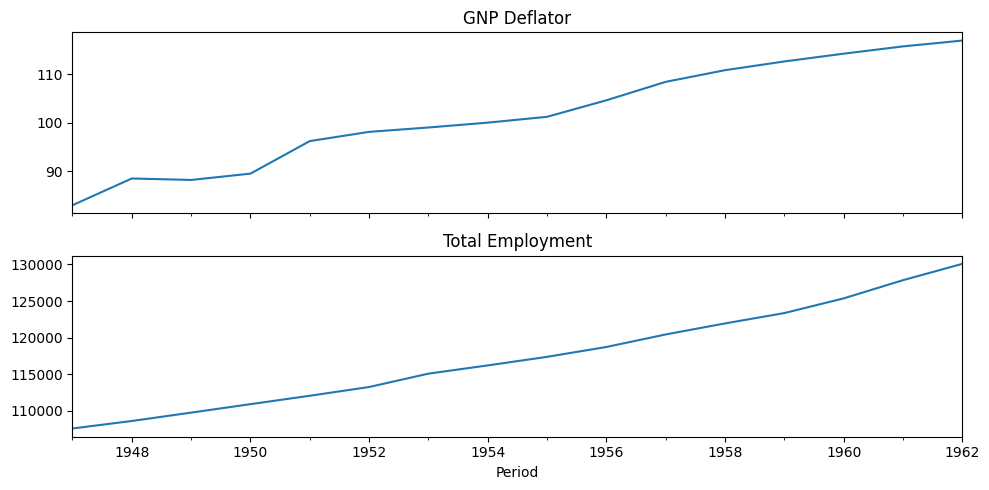

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

y["GNPDEFL"].plot(ax=axes[0], title="GNP Deflator")
y["POP"].plot(ax=axes[1], title="Total Employment")

plt.tight_layout()
plt.show()

### 1.1 Train / test split

`temporal_train_test_split` works the same as in the univariate case — it splits the DataFrame at a point in time, preserving all columns.

In [4]:
from sktime.split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=3)

fh = np.arange(1, 4)  # 3-step forecast horizon

print(f"Train: {len(y_train)} rows  |  Test: {len(y_test)} rows")
print(f"Columns: {list(y_train.columns)}")
y_test

Train: 13 rows  |  Test: 3 rows
Columns: ['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP']


,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1960,114.2,502601.0,3931.0,2514.0,125368.0
1961,115.7,518173.0,4806.0,2572.0,127852.0
1962,116.9,554894.0,4007.0,2827.0,130081.0


## 2. Apply-by-column: using any univariate forecaster

The simplest approach: use **any** univariate forecaster and let sktime handle the rest. When a univariate forecaster receives a multi-column DataFrame, sktime automatically fits one independent model per column.

This requires **zero extra code** — just pass the DataFrame to `fit`.

In [5]:
from sktime.forecasting.ets import AutoETS

forecaster_ets = AutoETS(auto=True, sp=1)
forecaster_ets.fit(y_train, fh=fh)

y_pred_ets = forecaster_ets.predict()
y_pred_ets

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1960,114.896148,499432.869381,2951.58936,2552.008502,124668.437964
1961,117.242850,519973.144857,2951.58936,2552.008502,125970.887287
1962,119.589552,540513.420333,2951.58936,2552.008502,127273.336609


Under the hood, sktime created six independent `AutoETS` models — one per column. You can access them via the `forecasters_` attribute:

In [6]:
forecaster_ets.forecasters_

,GNPDEFL,GNP,UNEMP,ARMED,POP
forecasters,AutoETS(auto=True),AutoETS(auto=True),AutoETS(auto=True),AutoETS(auto=True),AutoETS(auto=True)


Let's visualise the forecasts for two of the variables:

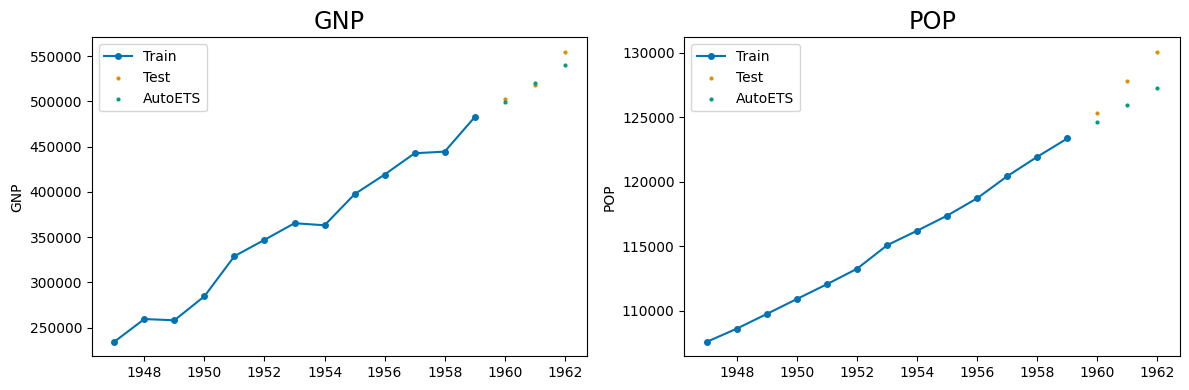

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col in zip(axes, ["GNP", "POP"]):
    plot_series(
        y_train[col],
        y_test[col],
        y_pred_ets[col],
        labels=["Train", "Test", "AutoETS"],
        ax=ax,
        title=col,
    )

plt.tight_layout()
plt.show()

**Key takeaway:** apply-by-column is effortless and gives you access to the entire library of univariate forecasters. However, each column is forecast independently — **cross-variable relationships are ignored**. If GNP and employment are correlated, the model won't exploit that.

## 3. Genuine multivariate forecasters

Some forecasters are designed to model **cross-variable dependencies** — they use the history of *all* variables to forecast *each* variable. sktime provides several such forecasters:

| Forecaster | Description | When to use |
|---|---|---|
| `VAR` | Vector AutoRegression | Stationary multivariate series |
| `VECM` | Vector Error Correction Model | Non-stationary but cointegrated series |
| `VARMAX` | VAR with Moving Average + exogenous | VAR with MA terms and exogenous variables |

You can discover all genuinely multivariate forecasters with the registry:

In [8]:
from sktime.registry import all_estimators

multivariate_forecasters = all_estimators(
    "forecaster",
    as_dataframe=True,
    filter_tags={"scitype:y": ["multivariate", "both"]},
)
print(f"Found {len(multivariate_forecasters)} multivariate forecasters")
multivariate_forecasters.head(15)

Found 36 multivariate forecasters


,name,object
0,AutoTS,<class 'sktime.forecasting.autots.AutoTS'>
1,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
2,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
3,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
4,ESRNNForecaster,<class 'sktime.forecasting.es_rnn.ESRNNForecas...
5,EnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.E...
6,FallbackForecaster,<class 'sktime.forecasting.compose._fallback.F...
7,FhPlexForecaster,<class 'sktime.forecasting.compose._fhplex.FhP...
8,ForecastByLevel,<class 'sktime.forecasting.compose._grouped.Fo...
9,ForecastKnownValues,<class 'sktime.forecasting.dummy.ForecastKnown...


### 3.1 VAR — Vector AutoRegression

`VAR` is the multivariate extension of the classic `AR` model. Each variable is modelled as a linear function of past values of *all* variables in the system. This allows the model to capture lead-lag relationships (e.g., GNP changes preceding employment changes).

In [9]:
from sktime.forecasting.var import VAR

forecaster_var = VAR()
forecaster_var.fit(y_train, fh=fh)

y_pred_var = forecaster_var.predict()
y_pred_var

,GNPDEFL,GNP,UNEMP,ARMED,POP
1960,116.605817,505938.002662,4073.371217,2693.935610,125004.172736
1961,118.824850,524876.696120,4609.163362,2676.326156,126684.589126
1962,121.422920,551157.431222,4765.381903,2619.980051,128354.652580


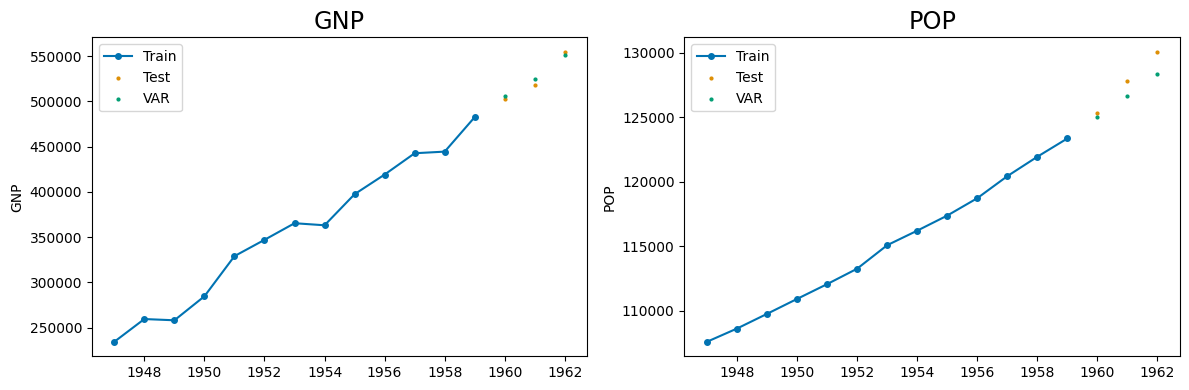

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col in zip(axes, ["GNP", "POP"]):
    plot_series(
        y_train[col],
        y_test[col],
        y_pred_var[col],
        labels=["Train", "Test", "VAR"],
        ax=ax,
        title=col,
    )

plt.tight_layout()
plt.show()

### 3.2 VECM — Vector Error Correction Model

When the individual series are non-stationary (they have trends) but move together over time — a property called **cointegration** — `VECM` is the right tool. It models the long-run equilibrium relationships between variables while also capturing short-run dynamics.

In [11]:
from sktime.forecasting.vecm import VECM

forecaster_vecm = VECM(deterministic="ci")
forecaster_vecm.fit(y_train, fh=fh)

y_pred_vecm = forecaster_vecm.predict()
y_pred_vecm

,GNPDEFL,GNP,UNEMP,ARMED,POP
1960,-4.018760e+02,-1.252892e+06,3.774817e+04,-1.545470e+05,9.916301e+04
1961,-3.901726e+04,-1.339483e+08,2.653248e+06,-1.193522e+07,-1.866033e+06
1962,-2.916263e+06,-1.002169e+10,1.974683e+08,-8.896618e+08,-1.484347e+08


### 3.3 Probabilistic multivariate forecasts

Genuine multivariate forecasters like `VAR` can also produce **prediction intervals**. The interface is exactly the same as for univariate forecasters:

In [12]:
y_pred_intervals = forecaster_var.predict_interval(coverage=0.90)
y_pred_intervals

GNPDEFL                        GNP                       UNEMP  \
             0.9                        0.9                         0.9   
           lower       upper          lower          upper        lower   
1960  114.126846  119.084787  491374.583695  520501.421629  3205.315223   
1961  116.274562  121.375139  505047.888319  544705.503921  3268.090371   
1962  118.536927  124.308913  528914.873706  573399.988737  3161.239934   

                         ARMED                         POP                 
                           0.9                         0.9                 
            upper        lower        upper          lower          upper  
1960  4941.427211  1942.425781  3445.445438  124623.198791  125385.146682  
1961  5950.236353  1579.449684  3773.202629  126160.565129  127208.613122  
1962  6369.523871  1288.646939  3951.313162  127772.267046  128937.038114

The result is a DataFrame with a multi-level column index: variable → coverage → lower/upper. This makes it easy to plot prediction intervals per variable:

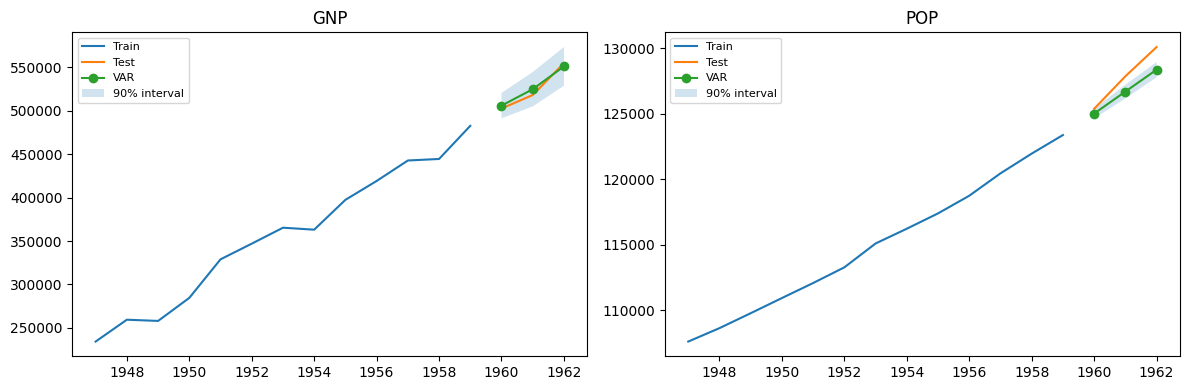

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col in zip(axes, ["GNP", "POP"]):
    ax.plot(y_train.index.to_timestamp(), y_train[col], label="Train")
    ax.plot(y_test.index.to_timestamp(), y_test[col], label="Test")
    ax.plot(y_pred_var.index.to_timestamp(), y_pred_var[col], label="VAR", marker="o")
    ax.fill_between(
        y_pred_intervals.index.to_timestamp(),
        y_pred_intervals[(col, 0.9, "lower")],
        y_pred_intervals[(col, 0.9, "upper")],
        alpha=0.2,
        label="90% interval",
    )
    ax.set_title(col)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 4. Reduction: multivariate forecasting with scikit-learn regressors

`VAR` is a linear model. What if you want to capture non-linear cross-variable relationships? The **reduction** approach lets you use any scikit-learn regressor as a multivariate forecaster.

sktime provides two flavours:

| Approach | Class | How it works |
|---|---|---|
| **VARReduce** | `VARReduce` | Tabularizes multivariate series into lagged features and fits one regressor per target column. Equivalent to a VAR but with any regressor (Lasso, Ridge, GradientBoosting, etc.) |
| **make_reduction** | `make_reduction` | General-purpose reduction that converts the forecasting problem into supervised regression |

### 4.1 VARReduce — a generalised VAR with any regressor

`VARReduce` creates lagged features from **all** variables and uses them to predict each variable. This means cross-variable information flows through the lag features, just like in VAR, but the underlying model can be non-linear.

In [14]:
from sklearn.linear_model import Ridge

from sktime.forecasting.var_reduce import VARReduce

# A Ridge-regularised VAR
forecaster_ridge = VARReduce(regressor=Ridge(alpha=1.0))
forecaster_ridge.fit(y_train, fh=fh)

y_pred_ridge = forecaster_ridge.predict()
y_pred_ridge

,GNPDEFL,GNP,UNEMP,ARMED,POP
1960,116.588537,505707.563124,4086.967651,2690.416192,125004.433764
1961,118.829655,525145.943497,4593.451384,2676.446439,126682.341255
1962,121.469100,551456.626753,4747.217406,2628.115796,128355.399918


You can swap in any scikit-learn regressor — `Lasso` for sparse VAR, `GradientBoostingRegressor` for non-linear relationships, `ElasticNet` for a combination:

### 4.2 make_reduction with multivariate data

`make_reduction` also works with multivariate data. It creates lagged features and wraps a scikit-learn regressor. When the input is multivariate, lags of all columns are included as features.

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

from sktime.forecasting.compose import make_reduction

forecaster_gb = make_reduction(
    GradientBoostingRegressor(n_estimators=50, max_depth=3),
    window_length=5,
    strategy="recursive",
)

forecaster_gb.fit(y_train, fh=fh)
y_pred_gb = forecaster_gb.predict()
y_pred_gb

,GNPDEFL,GNP,UNEMP,ARMED,POP
1960,112.557417,481803.227944,3946.985726,2597.513049,123339.933493
1961,112.557417,481803.227944,2483.383942,2597.513049,123339.933493
1962,112.557417,481803.227944,2400.647148,2597.513049,123339.933493


## 5. Column-specific forecasters

Sometimes different variables require different models — a trending variable may need a trend forecaster, while a noisy one may benefit from exponential smoothing. `ColumnEnsembleForecaster` lets you assign a **different forecaster to each column**.

In [16]:
from sktime.forecasting.compose import ColumnEnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import PolynomialTrendForecaster

# Use a subset of columns for clarity
y_sub = y[["GNP", "UNEMP", "POP"]]
y_train_sub, y_test_sub = temporal_train_test_split(y_sub, test_size=3)

# Assign a different forecaster to each column
column_forecaster = ColumnEnsembleForecaster(
    forecasters=[
        ("trend", PolynomialTrendForecaster(degree=1), "GNP"),
        ("ets", ExponentialSmoothing(), "UNEMP"),
        ("auto_ets", AutoETS(auto=True, sp=1), "POP"),
    ]
)

column_forecaster.fit(y_train_sub, fh=fh)
y_pred_col = column_forecaster.predict()
y_pred_col

,GNP,UNEMP,POP
1960,498723.384615,3513.537385,124668.437964
1961,519117.857143,3513.537385,125970.887287
1962,539512.329670,3513.537385,127273.336609


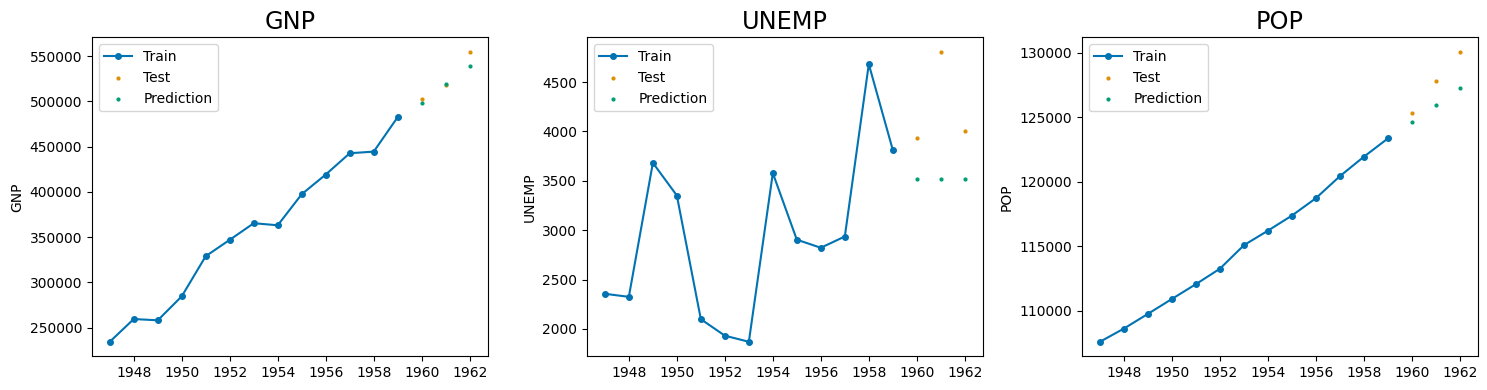

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, ["GNP", "UNEMP", "POP"]):
    plot_series(
        y_train_sub[col],
        y_test_sub[col],
        y_pred_col[col],
        labels=["Train", "Test", "Prediction"],
        ax=ax,
        title=col,
    )

plt.tight_layout()
plt.show()

## 6. Pipelines with multivariate data

Transformations and pipelines work seamlessly with multivariate series. When you chain a transformer with a forecaster using the `*` pipeline operator, the transformation is applied to **every column** and automatically inverted at prediction time.

### 6.1 Detrending + VAR

The Longley variables have strong trends. Removing them before fitting a VAR can improve forecasts, since VAR assumes stationarity.

In [18]:
from sktime.transformations.series.detrend import Detrender

# Build a pipeline: detrend → VAR → re-trend
pipe_detrend_var = Detrender() * VAR()
pipe_detrend_var.fit(y_train, fh=fh)

y_pred_detrend_var = pipe_detrend_var.predict()
y_pred_detrend_var

,GNPDEFL,GNP,UNEMP,ARMED,POP
1960,117.531547,506627.827442,3582.723242,3018.221689,124342.733532
1961,118.322735,516124.166795,4211.650656,3382.003856,125732.163789
1962,119.709385,539624.825202,4047.998196,3493.782677,126962.704341


### 6.2 Scaling + Reduction

Scaling all variables to a common range can help regression-based forecasters. Here we combine `MinMaxScaler` with a gradient boosting reduction:

In [19]:
from sklearn.preprocessing import MinMaxScaler

from sktime.transformations.series.adapt import TabularToSeriesAdaptor

scaler = TabularToSeriesAdaptor(MinMaxScaler())

pipe_scaled_gb = scaler * make_reduction(
    GradientBoostingRegressor(n_estimators=50, max_depth=3),
    window_length=5,
    strategy="recursive",
)

pipe_scaled_gb.fit(y_train, fh=fh)
y_pred_scaled_gb = pipe_scaled_gb.predict()
y_pred_scaled_gb

,GNPDEFL,GNP,UNEMP,ARMED,POP
1960,112.557417,481401.078329,3976.681552,2615.433657,123339.933493
1961,112.557417,481401.078329,2328.639416,2615.433657,123339.933493
1962,112.557417,481401.078329,1921.737269,2615.433657,123339.933493


## 7. Evaluating multivariate forecasts

Standard forecasting metrics apply to multivariate forecasts. With multiple columns, you can control **how to aggregate across variables** using the `multioutput` parameter:

| Value | Behaviour |
|---|---|
| `"uniform_average"` | Compute the metric per column, then average (default) |
| `"raw_values"` | Return the metric per column — useful for spotting which variable is hardest to forecast |

In [20]:
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
)

mape = MeanAbsolutePercentageError()
mape_per_col = MeanAbsolutePercentageError(multioutput="raw_values")

# Single-number summary
print("MAPE (averaged across variables):")
print(f"  AutoETS (by-column): {mape(y_test, y_pred_ets):.4f}")
print(f"  VAR:                 {mape(y_test, y_pred_var):.4f}")
print(f"  VECM:                {mape(y_test, y_pred_vecm):.4f}")
print(f"  Ridge VAR:           {mape(y_test, y_pred_ridge):.4f}")
print(f"  Detrend + VAR:       {mape(y_test, y_pred_detrend_var):.4f}")

MAPE (averaged across variables):
  AutoETS (by-column): 0.0759
  VAR:                 0.0393
  VECM:                27601.2674
  Ridge VAR:           0.0392
  Detrend + VAR:       0.0759


### 7.1 Per-variable breakdown

Use `multioutput="raw_values"` to get the metric for each column individually:

In [21]:
results = {
    "AutoETS (by-column)": mape_per_col(y_test, y_pred_ets),
    "VAR": mape_per_col(y_test, y_pred_var),
    "VECM": mape_per_col(y_test, y_pred_vecm),
    "Ridge VAR": mape_per_col(y_test, y_pred_ridge),
    "Detrend + VAR": mape_per_col(y_test, y_pred_detrend_var),
}

comparison = pd.DataFrame(results, index=y_test.columns).T
comparison.loc["Mean"] = comparison.mean()
comparison

,GNPDEFL,GNP,UNEMP,ARMED,POP
AutoETS (by-column),0.014146,0.011898,0.299465,0.040055,0.013959
VAR,0.028922,0.008770,0.088813,0.061788,0.008435
VECM,8430.131753,6108.179546,16613.172190,106468.887537,385.966200
Ridge VAR,0.029017,0.008611,0.089544,0.060378,0.008438
Detrend + VAR,0.025291,0.013161,0.074166,0.250453,0.016243
Mean,1686.045826,1221.644397,3322.744836,21293.860042,77.202655


## Key takeaways

* **Multivariate = multi-column DataFrame** — each column is a variable, the index is time. That's all sktime needs.
* **Any univariate forecaster** works on multivariate data out-of-the-box: sktime fits one clone per column automatically (apply-by-column). This is the simplest approach but ignores cross-variable dependencies.
* **Genuine multivariate forecasters** like `VAR` and `VECM` model cross-variable relationships. Use `VAR` for stationary data and `VECM` for cointegrated non-stationary data.
* **Reduction with `VARReduce` or `make_reduction`** lets you use any scikit-learn regressor (Ridge, Lasso, GradientBoosting, etc.) as a multivariate forecaster via lagged features.
* **`ColumnEnsembleForecaster`** lets you assign different forecasters to different columns.
* **Pipelines** with `Detrender`, `MinMaxScaler`, etc. work seamlessly — transformations are applied per column and automatically inverted at prediction time.
* **Metrics** support `multioutput` for per-column breakdowns or averaged summaries.

### Next

Proceed to the **hierarchical forecasting** tutorial to learn about forecasting multiple series in a hierarchical structure.

## References

[1] Lütkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Springer.

[2] Hyndman, R.J. and Athanasopoulos, G. (2021). *Forecasting: Principles and Practice*, 3rd edition. OTexts. [Chapter 12: Dynamic regression models](https://otexts.com/fpp3/dynamic.html).

[3] Johansen, S. (1991). "Estimation and hypothesis testing of cointegration vectors in Gaussian vector autoregressive models." *Econometrica*, 59(6), 1551–1580.